# 项目：基于迁移学习的人脸识别

以下为该项目的一般流程和实现的代码以及输出结果。

## 任务介绍

人脸识别是一个计算机视觉任务，任务是要通过一张带有人脸的图像，对图像中的人脸进行识别并判断是谁。关于人脸识别的任务，我们一定会用到2015年Google开发的FaceNet，这个模型由于其性能非常好而被广泛使用，并且该训练好的模型已经被开源。

因此，本项目的任务将要学习人脸识别任务，在此项目中，我们将先按课程所学到的知识亲手搭建一个卷积神经网络，然后，我们将用高级的网络结构，比如ResNet50再次进行人脸识别任务，最后我们将用到预训练好的FaceNet模型。在这个过程中，我们还会用到数据增强和人脸抽取技术来提升人脸识别的精确度。

在这个人脸识别项目中，我们将使用一个开源数据集[Five Celebrity Faces Dataset](kaggle.com/dansbecker/5-celebrity-faces-dataset)，这也是一个在Kaggle比赛中的一个数据集。我们也已经下载好了并放在`./5-celebrity-faces-dataset`中，数据集中包含五位名人的照片，Ben Affleck, Elton John, Jerry Seinfeld, Madonna, Mindy Kaling。文件下分`train`和`val`。

## 数据准备
我们首先要简单的观察数据，然后通过数据增强和人脸抽取技术对数据图像数据进行抽取。

### 显示一张图像

所有 train下面的图像文件名都存入 images 列表中，并将该图像的人名按顺序存于 images_name 中

In [1]:
import cv2
import matplotlib.pyplot as plt
import os
import random
import PIL
data_root = "./5-celebrity-faces-dataset/train/"

In [2]:
os.getcwd()
os.chdir('D:/百度网盘下载/Udacity/CN-Face-Recognition-master')
print(os.getcwd())

D:\百度网盘下载\Udacity\CN-Face-Recognition-master


In [3]:
# 把所有 train下面的图像文件名都存入 images 列表中，并将该图像的人名按顺序存于 images_name 中
images = []
images_name = []
for imgfolder in os.listdir(data_root):
    for filename in os.listdir(data_root + imgfolder):
        filename = data_root + imgfolder + '/' + filename
        images.append(filename)
        images_name.append(imgfolder)

从`images`中随机读取一张图像，使用 `cv2.imread`读取图像，然后使用`pyplot.imshow`显示图像。注意：你需要同时显示该图像对应的人名，以及打印该图像的`shape`。

随机选取一张照片：


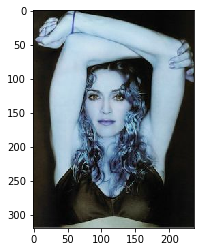

madonna
(320, 236, 3)


('./5-celebrity-faces-dataset/train/madonna/httpssmediacacheakpinimgcomxffecfafddjpg.jpg',
 'madonna')

In [4]:
# 从images 中随机读取一张图像，并获得该图像中的人名
def random_sample(images=images, images_name=images_name):
    print("随机选取一张照片：")
    #从 images 和 images_name 随机读取一个图像文件路径以及该图像的人名
    num = random.randint(0,len(images))
    im_file, im_name = images[num],images_name[num]
    # 使用 cv2.imread 读取图像文件
    img = cv2.imread(im_file)
    # 使用 plt.imshow 和 plt.show() 显示图像
    plt.imshow(img)
    plt.show()
    # 打印该图像的人名
    print(im_name)
    # 打印该图像的大小 shape
    print(img.shape)
    return im_file, im_name

random_sample(images, images_name)

可以多次运行上面的代码来多观察一些人物图像，以此来对数据有一个大致的认知

用`cv2.imread`读取所有数据并存入`train_x`中，然后用 0,1,2,3,4 来标记 Ben Affleck, Elton John, Jerry Seinfeld, Madonna, Mindy Kaling，并将所有`images_name`数据存入`train_y`中。

### 数据增强

首先，我们需要打印训练集的数量。

In [5]:
print(len(images))

93


可以看到，训练集的图像数量比较少，这对模型建模并学习图像数据到人名标签的映射关系增加了难度，所以这里需要做数据增强的工作。关于数据增强的基本原理和作用，可以参考——[Data Augmentation](https://machinelearningmastery.com/how-to-configure-image-data-augmentation-when-training-deep-learning-neural-networks/)。

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

#构造图像数据增强器

data_gen = ImageDataGenerator(
    rescale = 0.5, # 随机缩放图像RGB值的倍数
    rotation_range =40 , # 随机旋转图像的范围
    zoom_range =0.2 ,  # 随机缩放图像大小范围
    width_shift_range =0.2 ,  # 随机水平方向平移图像(fraction of total width)
    height_shift_range=0.2 ,  # 随机纵向平移图像(fraction of total height)
)


Using TensorFlow backend.


ModuleNotFoundError: No module named 'numpy.core._multiarray_umath'

SystemError: <class '_frozen_importlib._ModuleLockManager'> returned a result with an error set

ImportError: numpy.core._multiarray_umath failed to import

ImportError: numpy.core.umath failed to import

使用 `flow_from_directory` 遍历数据集 `./5-celebrity-faces-dataset/data`，来观察数据增强的表现。先得到一个图像迭代器，该迭代器每次都从路径里读取一个图像，并按照数据增强器的规则进行编辑图像

In [ ]:
# 直接运行，得到一个图像迭代器，该迭代器每次都从路径里读取一个图像，并按照数据增强器的规则进行编辑图像
dataflow_generator = data_gen.flow_from_directory(
    "./5-celebrity-faces-dataset/data",
    target_size=(160, 160),
    batch_size=1,
    color_mode='rgb',
    class_mode='categorical')

In [ ]:
# 从 迭代器中 读取10张图片，并显示图像

sample_count = 10
for image_data in dataflow_generator:
    # 使用 plt.imshow 和 plt.show() 显示图像
    plt.imshow(image_data[0][0].astype(int))
    plt.show()
    
    sample_count -= 1
    if sample_count <= 0:
        break  

**问题1**：观察以上人脸图像，简单说说产生的图像中存在哪些增强的部分，然后再详细阐述你对数据增强的思考，包括为什么数据增强能够帮助人脸识别？你需要参考一些论文，并列出你的引用。

**问题回答：**产生的图像中存在旋转、缩放、裁剪、平移等操作。数据增强是图像识别的重要流程，通过数据增强，不仅可以在训练数据不足的情况下增加训练数据，而且能够保证图像检测目标不变的情况下增加训练数据的多样性，提高模型的泛化能力。对于人脸识别，我们主要识别的是图像中的人脸部分是谁，通过数据增强，可以保证训练数据中同一张图像的人脸具有不同的形态，如大小，位置等，从而保证模型在真实预测场景下对复杂人脸识别的准确性。数据增强在图像识别中是被广泛使用的技术，从根本上扩大了训练数据集的大小并避免过拟合[1]。Jiang-Jing Lv等人[2]指出，通过地标摄动以及对人脸图像中发型、眼镜、姿势、照明等多种数据增强方式，有效地扩大了训练数据集，减轻了未对准，姿势变化，照明变化和部分遮挡以及训练过程中的过度拟合的影响。

References:

[1]Inoue H . Data Augmentation by Pairing Samples for Images Classification[J]. 2018.

[2]Lv J J , Shao X H , Huang J S , et al. Data augmentation for face recognition[J]. Neurocomputing, 2017, 230(MAR.22):184-196.

### 人脸抽取

在做人脸识别任务中，一项常用的图像数据处理的技术是人脸检测（Face Detection）。人脸检测是将输入的图片中的人脸部分自动检测出来，具体来说就是要通过预测一个矩形边界框（Bounding Box）从整个图像中定位人脸部分，这里的矩形边界框由矩形左下角坐标以及矩形高和宽来定义。人脸检测是一个比较成熟的任务，接下来在我们这个项目中，我们将使用 Multi-Task Cascaded Convolutional Neural Network，MTCNN，你也可以参考论文：[Joint Face Detection and Alignment Using Multitask Cascaded Convolutional Networks](https://arxiv.org/abs/1604.02878)，来学习人脸检测任务。

In [ ]:
# 运行下面代码，安装 mtcnn
#!pip install mtcnn

In [ ]:
# 定义人脸抽取的函数
from PIL import Image
from mtcnn.mtcnn import MTCNN
import numpy as np

def extract_face(filename, image_size=(160, 160)):
    # 加载图像
    image = Image.open(filename)
    # 转换RGB
    image = image.convert('RGB')
    # 转成 numpy.array 格式的数据
    image_data = np.asarray(image)
    # 创建一个人脸检测，
    detector = MTCNN()
    # 从图像中检测
    results = detector.detect_faces(image_data)
    # 返回的结果是图像中所有出现的人脸的矩形边界框，由于我们的图像中只有一张人脸，所所以只需要取结果中第一个
    box_x, box_y, width, height = results[0]['box']
    # 处理下标为负的情况
    box_x, box_y = abs(box_x), abs(box_y)
    box_x_up, box_y_up = box_x + width, box_y + height
    # 获得人脸部分的数据
    face = image_data[box_y:box_y_up, box_x:box_x_up]
    
    #把抽取出来的人脸图像 resize 至需要的图像大小，并返回numpy格式的数据
    face_array = np.asarray(cv2.resize(face,(160,160)))
    return face_array

ran_img_file, ran_img_name = random_sample()
img = extract_face(ran_img_file)
plt.imshow(img)
plt.show()
print(img.shape)

**问题2：**通过多次运行以上代码并观察人脸抽取后的图像，你认为人脸检测对人脸识别有帮助吗？为什么？你需要参考一些论文，并列出你的reference。

**回答问题：**人脸检测对人脸识别有较大的帮助。Erik Hjelmas、Boon Keelow[1]指出人脸检测是人脸识别比不可少的第一步，目的是从图像背景中定位和提取人脸区域。梁路宏等人指出[2]人脸检测是自动人脸识别系统中的一个关键环节，但是早期的人脸识别研究主要针对具有较强约束条件的人脸图象（如无背景的图象），往往假设人脸位置已知或很容易获得，因此人脸检测问题并未受到重视。近几年随着电子商务等应用的发展，人脸识别成为最有潜力的生物身份验证手段，这种应用背景要求自动人脸识别系统能够对一般环境图象具有一定的适应能力，由此所面临的一系列问题使得人脸检测开始作为一个独立的课题受到研究者的重视。综上所述，人脸检测是人脸识别的关键的第一步，通过人脸检测技术提取图像中关于人脸的区域，能够提高人脸识别的准确性，尤其是在复杂背景下的人脸识别。

参考文献：

[1]Hjelmas E , Low B K . Face Detection: A Survey[J]. Computer Vision & Image Understanding, 2001, 83(3):236-274.

[2]梁路宏, 艾海舟, 徐光祐, et al. 人脸检测研究综述[J]. 计算机学报, 2002(05):1-10.

### 构造数据

现在我们可以应用以上的数据增强和人脸检测技术来构造完整的数据。

这里可以直接使用前面定义好的图像数据增强器 `data_gen`，然后使用 [ImageDataGenerator](https://keras.io/preprocessing/image/)中的 `random_transform` 对单个图像做随机增强操作。

另外，在构造数据之前，你需要先构造一个人名到类别的映射，使得在构造数据的label的时候将string格式的人名转换为int格式的类别。

编程练习：
1. 你需要 构造人名字典，将 ben_afflek、elton_john、jerry_seinfeld、madonna、mindy_kaling 分别映射到 0-1-2-3-4
2. 定义 `load_dataset`函数，遍历train或者val文件夹，读取文件夹下5个人名文件夹，以该文件夹名映射至0到4 的标签；然后分别从人名文件夹中遍历所有图像文件，读取图像，如果是train文件夹下的图像，则需要用`data_gen.random_transform`来增强图像数据，增强次数为augment_times；如果是val文件夹下的图像，则不需要进行图像增强

In [ ]:
#构造人名字典，将 ben_afflek、elton_john、jerry_seinfeld、madonna、mindy_kaling 分别映射到 0-1-2-3-4
name_dict = {"ben_afflek":0,"elton_john":1,"jerry_seinfeld":2,"madonna":3,"mindy_kaling":4}

# TODO：定义数据加载函数，data_dir为文件路径，augment_times为数据增强次数，is_train为判断是训练集还是测试集（测试集不需要数据增强）
def load_dataset(data_dir = "./5-celebrity-faces-dataset/train/", augment_times=2, is_train=True):
    data_x = []
    data_y = []
    
    for imgfolder in os.listdir(data_dir):
        path = data_dir + imgfolder
        for filename in os.listdir(path):
            filename = path + '/' + filename
            img = extract_face(filename)
            print(img.shape)
            data_x.append(img)
            data_y.append(name_dict[imgfolder])
            if is_train :
                for _ in range(augment_times):
                    img_aug = data_gen.random_transform(img)
                    data_x.append(img_aug)
                    data_y.append(name_dict[imgfolder])   
    return data_x, data_y

train_x, train_y = load_dataset("./5-celebrity-faces-dataset/train/", augment_times=2, is_train=True)
test_x, test_y = load_dataset("./5-celebrity-faces-dataset/val/", is_train=False)

# 最终构造好训练和测试数据
train_X = np.asarray(train_x)
train_Y = np.eye(5)[np.array(train_y)]
test_X = np.asarray(test_x)
test_Y = np.eye(5)[np.array(test_y)]

In [ ]:
len(train_X)

### 构建一个卷积神经网络

创建一个卷积神经网络来对人脸进行分类。在你代码块的最后，执行 `model.summary()` 来输出你模型的总结信息。
。

![Sample CNN](images/sample_cnn.png)

**问题3：**在下方的代码块中尝试使用 Keras 搭建卷积网络的架构，并回答相关的问题。

1. 你可以尝试自己搭建一个卷积网络的模型，那么你需要回答你搭建卷积网络的具体步骤（用了哪些层）以及为什么这样搭建。
2. 你也可以根据上图提示的步骤搭建卷积网络，那么请说明如上的架构能够在该问题上取得的表现。


**回答问题：**根据上图提示的步骤搭建的卷积网络，最终在测试集上的预测准确率是40%，模型表现效果不佳。

In [ ]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential

model = Sequential()

### TODO: 定义你的网络架构
model.add(Conv2D(filters=32,kernel_size=2,padding='same',activation='relu',input_shape=(160,160,3)))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))
model.add(Conv2D(filters=32,kernel_size=2,padding='same',activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))
model.add(Conv2D(filters=32,kernel_size=2,padding='same',activation='relu'))
model.add(GlobalAveragePooling2D())
model.add(Dropout(0.2))
model.add(Dense(5,activation='softmax'))

model.summary()

In [ ]:
train_X.shape

In [ ]:
# 直接运行编译模型和训练模型
#计算CNN模型运行的时间
import time
start_cnn = time.time()

# 编译模型
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
# 模型训练
model.fit(train_X, train_Y, batch_size=8, epochs=50)

end_cnn = time.time()
running_time_cnn = end_cnn - start_cnn
print("CNN模型训练50轮的时间是：{}".format(running_time_cnn))

In [ ]:
preds_Y = model.predict(test_X)
preds_Y

#### 模型测试

你需要编写一个自动测试模型准确率的函数。

In [ ]:
def metric_accuracy(model, test_X, test_Y, model_name):
    preds_Y = model.predict(test_X)
    #通过预测值preds_Y以及真实值test_Y，来计算准确率
    correct = 0
    for pr,y in zip(preds_Y,test_Y):
        pr_cls = np.argmax(pr)
        if y[pr_cls] == 1:
            correct +=1
    accuracy = correct/len(preds_Y)
    
    print("%s Accuracy: %.3f" % (model_name, accuracy))
    
metric_accuracy(model, test_X, test_Y, "Simple CNN")

### 进阶 CNN 模型架构
在计算机视觉任务中，有一些复杂的高级CNN模型架构，比如ResNet、VGG、Inception 等等，他们能够对图像有一个非常好的表达。并且，已经有人把这些模型在非常大的图像数据上训练好了参数，这使得预训练的大模型能够对图像有一个很好的特征表达。这种在大规模图像数据上学到的图像特征，能够迁移到人脸图像的特征表示。

在这一小节，我们利用预训练好的 ResNet50,抽取图像特征，然后再去做人脸识别。虽然 ResNet50 在各种图像上面进行预训练的，但是该模型对图像结构特征信息的学习也能够帮助人脸识别任务中的预测。


In [ ]:
import keras 
from keras.models import Model, Sequential

# 模型底层使用 ResNet50 对原始图像进行建模，特征抽取
resnet50_weights = "./models/resnet50_weights.h5"
resnet = keras.applications.resnet50.ResNet50(weights=None, include_top=False, input_shape=(160, 160, 3))
resnet.load_weights(resnet50_weights)

# 自己定义模型顶层，使用抽取后的特征进行人脸识别
resnet_face = Sequential()
resnet_face.add(Flatten(input_shape=resnet.output_shape[1:]))
resnet_face.add(Dense(5,activation='softmax'))


resnet_face_model = Model(inputs=resnet.input, outputs=resnet_face(resnet.output))
resnet_face_model.summary()


In [ ]:
# 设置同样的训练参数，直接运行
#计算ResNet模型训练的时间
start_resnet = time.time()

## 编译模型
resnet_face_model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
# 模型训练
resnet_face_model.fit(train_X, train_Y, batch_size=8, epochs=50)

end_resnet = time.time()
running_time_resnet=end_resnet - start_resnet
print("ResNet模型训练50轮的时间是：{}".format(running_time_resnet))

模型测试

In [ ]:
# 直接运行，测试 resnet_face_model 的准确率
metric_accuracy(resnet_face_model, test_X, test_Y, "ResNet50")


**问题5：**对比 ResNet50 模型和 CNN 模型的结果，请你分析为什么 ResNet50 模型能够取得更好的结果？

**回答问题：**与一般的CNN模型相比，ResNet50模型能够取得更好的结果主要是因为：①Resnet50模型已经在非常大的图像集中训练出最优参数，使得该预训练的模型能够对图像有一个更好地特征表达，通过迁移学习，将该表达应用于人脸图像的识别，提高了人脸识别的准确率。②ResNet50模型的深度更深，达到50layers,远大于我们的CNN模型，同时ResNet50模型的架构更具有技术性，REsNet50是对残差的学习，使得ResNet50模型在很深的层数下，仍能突破精确度饱和的瓶颈[1]。

参考文献：

[1]He K, Zhang X, Ren S, et al. Deep Residual Learning for Image Recognition[C]. computer vision and pattern recognition, 2016: 770-778


**问题6：**上面我们使用了预训练好的 ResNet50，即`resnet.load_weights(resnet50_weights)`，那么加载预训练好的参数对该任务有帮助吗？你需要通过做对比实验，即不加载预训练好的参数，然后在下面的代码框中重新跑一遍 ResNet50 的模型，来作为对比说明加载预训练是否有帮助

**回答问题：**加载预训练好的参数对任务有帮助，提高了模型在测试集上的准确率。实际上，未训练的REsNet50模型表现比一般的CNN模型还要差。

In [ ]:
# 重新跑一遍不加载预训练参数的 ResNet50 的模型，请在此处写完整的code

resnet = keras.applications.resnet50.ResNet50(weights=None, include_top=False, input_shape=(160, 160, 3))


# 定义模型顶层，使用抽取后的特征进行人脸识别
resnet_face = Sequential()
resnet_face.add(Flatten(input_shape=resnet.output_shape[1:]))
resnet_face.add(Dense(2048, activation="relu"))
resnet_face.add(Dropout(0.5))
resnet_face.add(Dense(1024, activation="relu"))
resnet_face.add(Dropout(0.5))

resnet_face.add(Dense(5,activation='softmax'))


resnet_no_pretrain = Model(inputs=resnet.input, outputs=resnet_face(resnet.output))
resnet_no_pretrain.summary()



In [ ]:
# 测试 resnet_no_pretrain 的准确率
metric_accuracy(resnet_no_pretrain, test_X, test_Y, "ResNet50")

### FaceNet 

上一小节中，我们利用了预训练好的 ResNet50 来抽取图像特征，而这一小节我们将利用预训练好的 FaceNet 来抽取人脸特征。我们已经知道 ResNet50 是在大规模数据上建模学习图像特征的，这里面的数据是多种多样的，不限制于人脸图像，而 [FaceNet](https://arxiv.org/pdf/1503.03832.pdf) 是专门对于人脸进行特征抽取的工具。

In [ ]:
# 使用 load_model 从`./models/facenet_keras.h5` 加载模型
from keras.models import load_model

# 模型底层使用 FaceNet 对原始图像进行建模，特征抽取
# 加载预训练好的 FaceNet 模型。
facenet_keras = "./models/facenet_keras.h5"
facenet_model =load_model(facenet_keras)
print("FaceNet model loaded...")


# 自定义模型顶层，使用抽取后的特征进行人脸识别
facenet_face = Sequential()
facenet_face.add(Dense(1024, input_shape=facenet_model.output_shape, activation="relu"))
facenet_face.add(Dropout(0.5))

facenet_face.add(Dense(5,activation='softmax'))


facenet_face_model = Model(inputs=facenet_model.input, outputs=facenet_face(facenet_model.output))
facenet_face_model.summary()


In [ ]:
train_XX = []
for x in train_X:
    x_image = Image.fromarray(x)
    x_image = x_image.resize((160, 160))
    train_XX.append(np.asarray(x_image))
train_X = np.array(train_XX)
train_X[0].shape

In [ ]:
#计算FaceNet模型训练的时间
start_facenet = time.time()
## 编译模型
facenet_face_model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
# 模型训练
facenet_face_model.fit(train_X, train_Y, batch_size=8, epochs=50)

end_facenet = time.time()
running_time_facenet = end_facenet - start_facenet
print("FaceNet模型训练50轮的时间是：{}".format(running_time_facenet))

In [ ]:
test_XX = []
for x in test_X:
    x_image = Image.fromarray(x)
    x_image = x_image.resize((160, 160))
    test_XX.append(np.asarray(x_image))
test_X = np.array(test_XX)
test_X[0].shape

preds_Y = facenet_face_model.predict(test_X)
correct = 0.
for pr, y in zip(preds_Y, test_Y):
    pr_cls = np.argmax(pr)
    if y[pr_cls] == 1:
        correct += 1
accuracy = correct / len(preds_Y)
print("FaceNet Accuracy: %.3f" % accuracy)

**问题7：**评价 FaceNet 模型的效果，并指出为什么 FaceNet 比上一小节中 ResNet 的效果要好。

**回答问题：**FaceNet在测试集上的准确率为80%，比ResNet模型的效果好。与ResNet相比，FaceNet模型取得较好效果的原因主要是：主要是利用相同人脸在不同角度等姿态的照片下有高内聚性、不同人脸有低耦合性，提出的一种人脸识别方法,没有用传统的softmax的方式去进行分类学习，而是抽取其中某一层作为特征，学习一个从图像到欧式空间的编码方法，然后基于这个编码再做人脸识别、人脸验证和人脸聚类等[1、2]。

参考文献与博文链接：

[1]Schroff F, Kalenichenko D, Philbin J, et al. FaceNet: A unified embedding for face recognition and clustering[C]. computer vision and pattern recognition, 2015: 815-823.

[2]https://www.cnblogs.com/carle-09/p/10455484.html 

**问题8：**
- 首先你需要在下方画一个表格，将上面所做的实验结果都列出来。
- 然后总结此项目，你认为在这个**人脸识别**项目中，哪些技术对识别准确率起比较重要的作用？请结合以上的实验结果分析。
- 最后，你再简要说说还有哪些技术对人脸识别任务有较大的帮助？列出你的references

**回答问题：**
实验结果总结

|Models|Accuracy|
|---|---|
|CNN|42%|
|ResNet50 no-pretrain|85%|
|ResNet50 pretrain|60%|
|FaceNet|80%|